# Visual Question Answering using Multimodal Transformer Models

## Import necessary libraries & set up the environment

In [36]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,            
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [37]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

In [38]:
'''device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')   '''
device = torch.device("cpu")

## Load the Processed [DAQUAR Dataset](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/vision-and-language/visual-turing-challenge/)

All the questions have 1-word/phrase answer, so we consider the entire vocabulary of answers available (*answer space*) & treat them as labels. This converts the visual question answering into a multi-class classification problem.

In [39]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join("DAQUAR","data_train.csv"),
        "test": os.path.join("DAQUAR", "data_eval.csv")
    }
)

with open(os.path.join("DAQUAR", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 6795
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 5673
    })
})

### Look at some of the Question/Image/Answer combinations

In [40]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join("DAQUAR", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

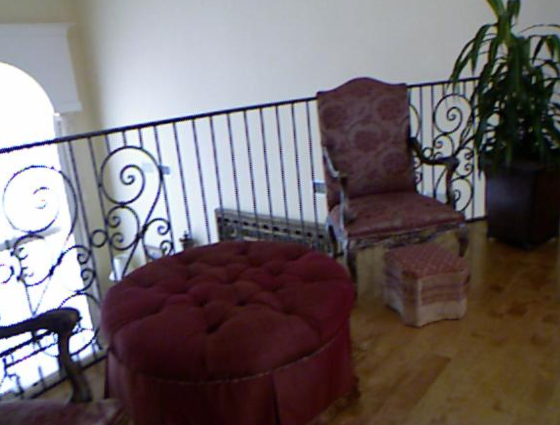

Question:	 what is to the right of the chair
Answer:		 plant (Label: 390)


In [41]:
showExample()

### Create a Multimodal Collator for the Dataset

This will be used in the `Trainer()` to automatically create the `Dataloader` from the dataset to pass inputs to the model

The collator will process the **question (text)** & the **image**, and return the **tokenized text (with attention masks)** along with the **featurized image** (basically, the **pixel values**). These will be fed into our multimodal transformer model for question answering.

In [42]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("DAQUAR", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

## Defining the Multimodal VQA Model Architecture

Multimodal models can be of various forms to capture information from the text & image modalities, along with some cross-modal interaction as well.
Here, we explore **"Fusion" Models**, that fuse information from the text encoder & image encoder to perform the downstream task (visual question answering). 

The text encoder can be a text-based transformer model (like BERT, RoBERTa, etc.) while the image encoder could be an image transformer (like ViT, Deit, BeIT, etc.). After passing the tokenized question through the text-based transformer & the image features through the image transformer, the outputs are concatenated & passed through a fully-connected network with an output having the same dimensions as the answer-space.

Since we model the VQA task as a multi-class classification, it is natural to use the *Cross-Entropy Loss* as the loss function.

In [43]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):
     
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

### Define a Function to Create the Multimodal VQA Models along with their Collators

We plan to experiment with multiple pretrained text & image encoders for our VQA Model. Thus, we will have to create the corresponding collators along with the model (tokenizers, featurizers & models need to be loaded from same pretrained checkpoints)

In [44]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

## Performance Metrics from Visual Question Answering

### Wu and Palmer Similarity

The Wu & Palmer similarity is a metric to calculate the sematic similarity between 2 words/phrases based on the position of concepts $c_1$ and $c_2$ in the taxonomy, relative to the position of their **_Least Common Subsumer_** $LCS(c_1, c_2)$. *(In an directed acyclic graph, the Least Common Subsumer is the is the deepest node that has both the nodes under consideration as descendants, where we define each node to be a descendant of itself)*

WUP similarity works for single-word answers (& hence, we use if for our task), but doesn't work for phrases or sentences.

`nltk` has an implementation of Wu & Palmer similarity score based on the WordNet taxanomy. Here, we have adapted the [implementation of Wu & Palmer similarity as defined along with the DAQUAR dataset](https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/calculate_wups.py).


In [45]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

In [46]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [47]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['tablecloth', 'iphone', 'coffee_table', 'rope', 'saucer']
['piece_of_wood', 'package_of_bottled_water', 'vegetable_peeler', 'utensil_container', 'clothing_detergent']
Predictions vs Labels:  0.0
Labels vs Labels:  1.0


In [48]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

In [49]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.44.1', '0.33.0')

## Model Training & Evaluation

### Define the Arguments needed for Training

In [50]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training 
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16=True,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

/home/qubit/anaconda3/envs/vqa/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [51]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()
    
    return collator, model, train_multi_metrics, eval_multi_metrics

In [52]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

/home/qubit/anaconda3/envs/vqa/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/qubit/anaconda3/envs/vqa/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/qubit/anaconda3/envs/vqa/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


{'loss': 5.8186, 'grad_norm': 5.451475620269775, 'learning_rate': 4.535211267605634e-05, 'epoch': 0.4694835680751174}
{'eval_loss': 5.10804557800293, 'eval_wups': 0.13541637030232434, 'eval_acc': 0.08496386391679887, 'eval_f1': 0.001437222338542553, 'eval_runtime': 59.855, 'eval_samples_per_second': 94.779, 'eval_steps_per_second': 2.974, 'epoch': 0.4694835680751174}
{'loss': 4.9995, 'grad_norm': 6.62795877456665, 'learning_rate': 4.0657276995305166e-05, 'epoch': 0.9389671361502347}
{'eval_loss': 4.6941237449646, 'eval_wups': 0.14578985764768232, 'eval_acc': 0.09201480698043363, 'eval_f1': 0.0023021134873074762, 'eval_runtime': 50.3672, 'eval_samples_per_second': 112.633, 'eval_steps_per_second': 3.534, 'epoch': 0.9389671361502347}
{'loss': 4.6774, 'grad_norm': 5.5789875984191895, 'learning_rate': 3.596244131455399e-05, 'epoch': 1.408450704225352}
{'eval_loss': 4.440593719482422, 'eval_wups': 0.17337919372437774, 'eval_acc': 0.11651683412656443, 'eval_f1': 0.0034092152978458384, 'eval_

In [53]:
eval_multi_metrics

{'eval_loss': 3.8706634044647217,
 'eval_wups': 0.26700956961906736,
 'eval_acc': 0.2124096597919972,
 'eval_f1': 0.011473625150753612,
 'eval_runtime': 56.0638,
 'eval_samples_per_second': 101.188,
 'eval_steps_per_second': 3.175,
 'epoch': 5.0}

## Examples of Model Inferencing

### Loading the Model from Checkpoint

In [73]:
'''model = MultimodalVQAModel()

# We use the checkpoint giving best results
model.load_state_dict(torch.load(os.path.join("checkpoint", "bert_vit", "checkpoint-1065", "model.safetensors")))
model.to(device) '''
from safetensors.torch import load_file

# Load the model architecture
model = MultimodalVQAModel()

# Load the weights from the safetensors file
weights = load_file(os.path.join("checkpoint", "bert_vit", "checkpoint-1065", "model.safetensors"))

# Update the model's state dict with the loaded weights
model.load_state_dict(weights)

# Move the model to the correct device (e.g., GPU or CPU)
model.to(device)


MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [83]:
sample = collator(dataset["test"][2005:2010])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

### Pass the Samples through the Model & inspect the Predictions

In [84]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

: 

In [80]:
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

array([510, 510, 564, 568,  10])

*********************************************************


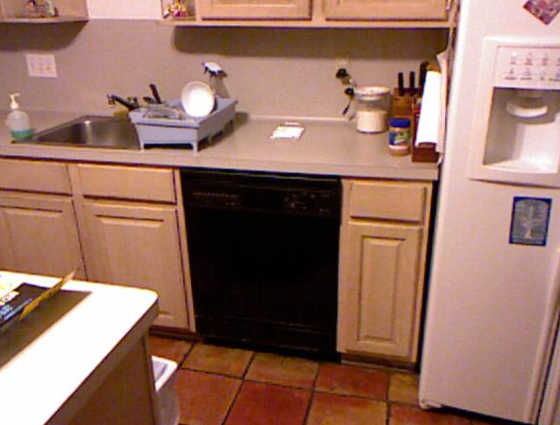

Question:	 what is on the left side of the sink
Answer:		 bottle_of_hand_wash_liquid (Label: 64)
Predicted Answer:	 towel
*********************************************************
*********************************************************


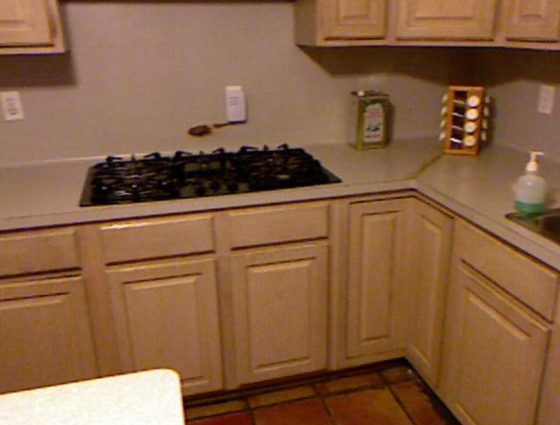

Question:	 what is on the left side of the container
Answer:		 stove (Label: 478)
Predicted Answer:	 towel
*********************************************************
*********************************************************


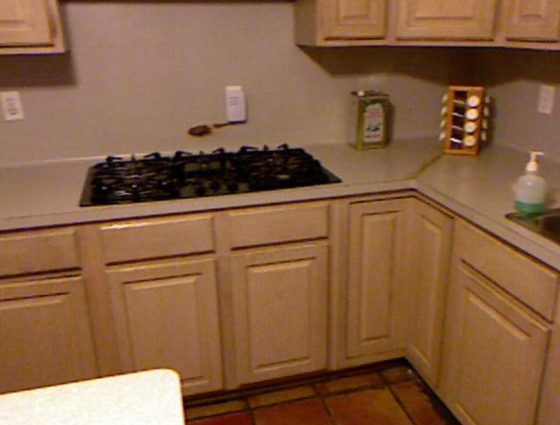

Question:	 what is the colour of the liquid
Answer:		 green (Label: 251)
Predicted Answer:	 white
*********************************************************
*********************************************************


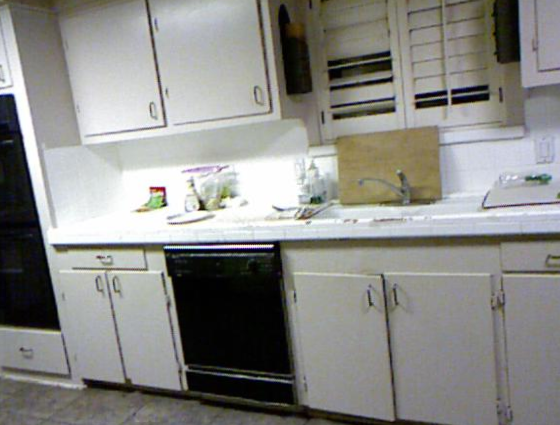

Question:	 what is behind the tap
Answer:		 wooden_plank (Label: 577)
Predicted Answer:	 window
*********************************************************
*********************************************************


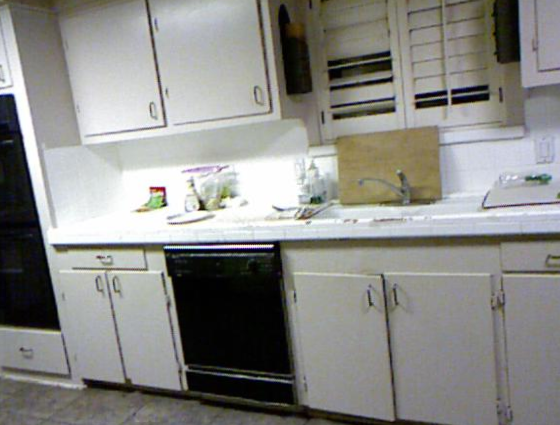

Question:	 how many drawers are there
Answer:		 2 (Label: 10)
Predicted Answer:	 2
*********************************************************


In [82]:
for i in range(2005, 2020):
    print("*********************************************************")
    showExample(train=False, id=i)
    print("Predicted Answer:\t", answer_space[preds[i-2005]])
    print("*********************************************************")

## Inspecting Model Size

In [70]:
def countTrainableParameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of trainable parameters:\t{0:,}".format(num_params))

In [71]:
countTrainableParameters(model) # For BERT-ViT model

No. of trainable parameters:	196,956,998
